# Mask R-CNN - Squirrel Monkey Segmentation

In [1]:
# Gets rid of a HOST of deprecation warnings for Matterport 
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf 

# and Tensorflow
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import skimage
from termcolor import colored

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [3]:
# Check tf version
print(tf.__version__)
print(tf.test.is_gpu_available())

1.13.1
True


## Configurations


In [4]:
class MonkeysConfig(Config):
    # Give the configuration a recognizable name
    NAME = "monkeys"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 monkey

    # Use large image sizes for greater accuracy
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = MonkeysConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences


In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Handles loading images and masks for the custom dataset


In [6]:
import json
MONKEY_CLASS_ID_STR = "monkey"


class MonkeysDataset(utils.Dataset):
    def load_monkeys(self, dataset_dir, subset):
        """Load a subset of the Monkey dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """

        # Add classes
        self.add_class(MONKEY_CLASS_ID_STR, 1, MONKEY_CLASS_ID_STR)

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        num_images_added = 0
       # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(
            open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes']
                            for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, "images", a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                MONKEY_CLASS_ID_STR,
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

            num_images_added += 1
            print(colored(f"Loading images {num_images_added}/{len(annotations)}"), end='\r')

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a monkey dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != MONKEY_CLASS_ID_STR:
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == MONKEY_CLASS_ID_STR:
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


# Loading Dataset

Ensure the dataset is in the following form:

dirName  
└── train  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── a.jpg  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── b.jpg  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── c.jpg  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── via_region_data.json  
└── val  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── c.jpg  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── d.jpg  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── e.jpg  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── via_regon_data.json  

In [10]:
# Training dataset.

DATASET_DIR = "F:\\Adam\\Pictures\\AucklandZooImages\\eval2 (60) romy rattaplan"

In [9]:
# Annotated using: https://www.robots.ox.ac.uk/~vgg/software/via/

dataset_train = MonkeysDataset()
dataset_train.load_monkeys(DATASET_DIR, "train")
dataset_train.prepare()


In [11]:
# Validation dataset
dataset_val = MonkeysDataset()
dataset_val.load_monkeys(DATASET_DIR, "val")
dataset_val.prepare()

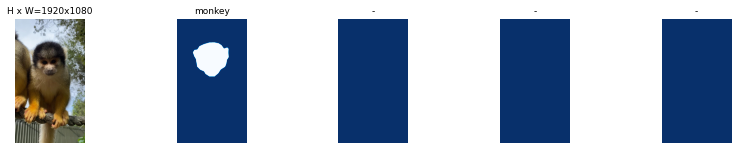

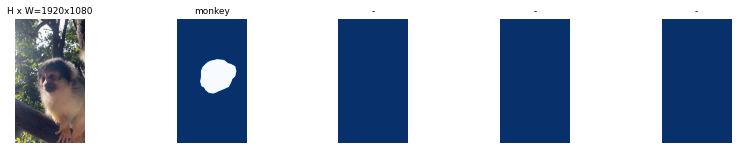

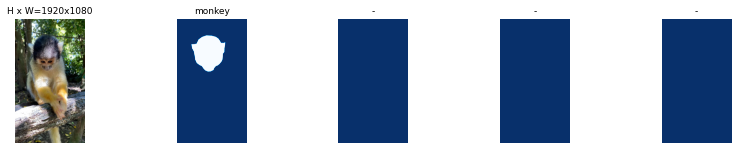

In [12]:
# show previews from the training dataset
# dataset_disp = dataset_train
dataset_disp = dataset_val

# Load and display random samples
image_ids = np.random.choice(dataset_disp.image_ids, 3)
for image_id in image_ids:
    image = dataset_disp.load_image(image_id)
    mask, class_ids = dataset_disp.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_disp.class_names)

## Create Model


In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 20


## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.


In [12]:
NUM_EPOCHS = 10

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='heads')


Starting at epoch 5. LR=0.001

Checkpoint Path: e:\Mask_RCNN_TF1\Mask_RCNN\logs\monkeys20211011T1425\mask_rcnn_monkeys_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

In [22]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")


Starting at epoch 10. LR=0.0001

Checkpoint Path: e:\Mask_RCNN_TF1\Mask_RCNN\logs\monkeys20211011T1425\mask_rcnn_monkeys_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

In [23]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection


In [7]:
class InferenceConfig(MonkeysConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  e:\Mask_RCNN_TF1\Mask_RCNN\logs\monkeys20211011T1425\mask_rcnn_monkeys_0020.h5
Re-starting from epoch 20


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1920.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  109.00000  max:  353.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


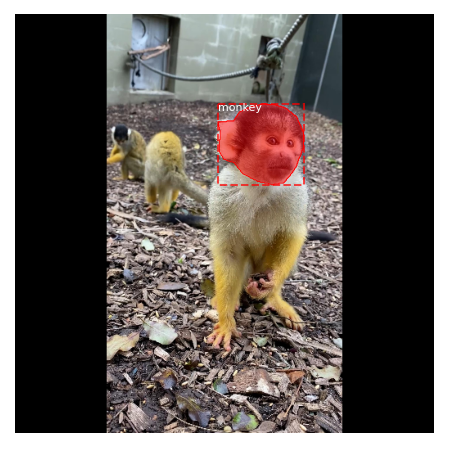

In [14]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


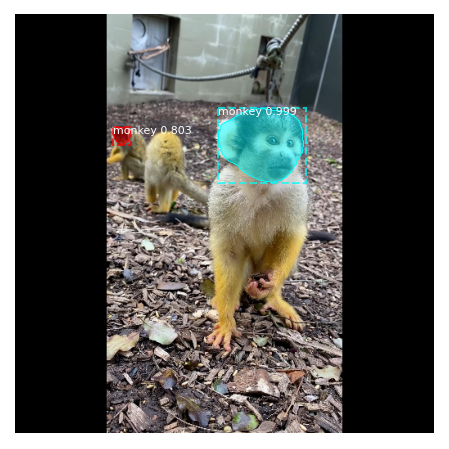

In [15]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'],
                            r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())


## Evaluation


In [16]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 10)

image_ids = dataset_val.image_ids

APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.975


In [8]:
import cv2
from os import makedirs
from pathlib import Path

def get_image_paths_and_output_dir(directory):
    from imghdr import what # used to ensure an image
        
    image_paths = sorted([directory / f for f in Path(directory).glob("**/*") if f.is_file() and what(f) != None])

    extraction_directory_path = Path(directory)
    output_dir = extraction_directory_path.parent.absolute() / (str(extraction_directory_path.name) + "_extracted")
    return image_paths, output_dir

def extract_faces(extraction_directory: str):

    image_paths, output_dir = get_image_paths_and_output_dir(extraction_directory)

    try:
        makedirs(output_dir, exist_ok=False)
    except Exception:
        pass

    
    # loop through all pictures in the directory and extract the region of interest
    for c in range(0, len(image_paths)):
        # load the picture
        image = skimage.io.imread(image_paths[c])
        # Run object detector
        results = model.detect([image], verbose=0)[0]
        # loop through the "results" to extract all regions of interest in the image
        
        try:
            # for i in range(0, 1):  # results["masks"].shape[2]):
            
            # our best prediction appears to be our first
            mask_choice = 0

            # get the coordinates of the box containing the region of interest
            x = results["rois"][mask_choice][0]
            y = results["rois"][mask_choice][1]
            w = results["rois"][mask_choice][2]
            h = results["rois"][mask_choice][3]

            # transform every pixel that is not part of the region of interest to black
            mask = results["masks"][:, :, mask_choice].astype(np.uint8)
            contours, im2 = cv2.findContours(
                mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            stencil = np.zeros(image.shape).astype(image.dtype)
            color = [255, 255, 255]
            cv2.fillPoly(stencil, contours, color)
            result = cv2.bitwise_and(image, stencil)

            # extract the box containing the region of interest and save the image
            result = result[x:w, y:h]
            skimage.io.imsave(output_dir / image_paths[c].name, result)
            print(output_dir / image_paths[c].name)
        except: 
            print(colored(f"Skipping file: {image_paths[c].name}", 'red'))

In [13]:
named_images_directory = (Path(DATASET_DIR) / "val").glob('*/')

individual_monkey_dirs = [d for d in named_images_directory if os.path.isdir(d)]

for individual_dir in [d for d in individual_monkey_dirs]:
    extract_faces(individual_dir)

F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val\images_extracted\IMG_1716_00108048.jpg
F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val\images_extracted\IMG_1716_00108053.jpg
F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val\images_extracted\IMG_1716_00108088.jpg
F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val\images_extracted\IMG_1716_00108194.jpg
F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val\images_extracted\IMG_1716_00108208.jpg
F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val\images_extracted\IMG_1716_00108211.jpg
F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val\images_extracted\IMG_1716_00108225.jpg
F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val\images_extracted\IMG_1723_00108033.jpg
F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val\images_extracted\IMG_1723_00108087.jpg
F:\Adam\Pictures\AucklandZooImages\eval2 (60) romy rattaplan\val